Ensemble Error

In [3]:
import math
from scipy.special import comb
n_classifier = 11
k_start = int(math.ceil(n_classifier / 2.))
print(k_start)

6


In [4]:
error = 0.25
probs = [comb(n_classifier, k) *
    error**k *
    (1-error)**(n_classifier - k)
    for k in range(k_start, n_classifier + 1)]

In [6]:
sum(probs)

0.03432750701904297

In [22]:
import numpy as np
x = np.bincount([0,0,1,1,1,2,2])
y = np.argmax(x)
y

1

Weighted majority vote

In [23]:
ex = np.array([[0.9, 0.1],
    [0.8, 0.2],
    [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

Implementing Majority Vote Classifier in Python

In [32]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights = None):

        self.classifiers = classifiers
        self.named_classifiers = {
            key: value for key, value in _name_estimators(classifiers)
        }
        self.vote = vote
        self.weights = weights
    
    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability'"
                             f"or 'classlabel'"
                             f"; got (vote = {self.vote})")
        
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and weights must be equal'
                             f' got {len(self.weights)} weights,'
                             f' {len(self.classifiers)} classifiers')
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis = 1)
        else:
            predictions = np.asarray([
                clf.predict(X) for clf in self.classifiers_
                ]).T
            maj_vote = np.apply_along_axis(
                lambda x: np.argmax(np.bincount(x, weights = self.weights)),axis = 1, arr = predictions
            )
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis = 0,weights = self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        if not deep:
            return super().get_params(deep = False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key , value in step.get_params(
                    deep=True).items():
                    out[f'{name}__{key}'] = value
            return out

In [33]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [34]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
    test_size=0.5,
    random_state=1,
    stratify=y)

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np
clf1 = LogisticRegression(penalty='l2',
    C=0.001,
    solver='lbfgs',
    random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,
    criterion='entropy',
    random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,
    p=2,
    metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()],
    ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
    ['clf', clf3]])
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
    X=X_train,
    y=y_train,
    cv=10,
    scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} '
    f'(+/- {scores.std():.2f}) [{label}]')


10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]


ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [36]:
mv_clf = MajorityVoteClassifier(
    classifiers=[pipe1, clf2, pipe3]
    )
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
    X=X_train,
    y=y_train,
    cv=10,
    scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} '
    f'(+/- {scores.std():.2f}) [{label}]')

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np

In [38]:
clf1 = LogisticRegression(penalty='l2',solver='lbfgs',C = 0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,criterion='entropy',random_state=1)
clf3 = KNeighborsClassifier(n_neighbors=1,p = 2,metric='minkowski')
#clf4 = SVC(probability=True)

pipe1 = Pipeline([('sc',StandardScaler()), ('clf',clf1)])
pipe2 = Pipeline([('sc',StandardScaler()), ('clf',clf2)])
pipe3 = Pipeline([('sc',StandardScaler()), ('clf',clf3)])
#pipe4 = Pipeline([('sc',StandardScaler()), ('clf',clf4)])

clf_labels = ['Logistic Regression', 'Decision tree classifier', 'KNN','Majority Voting']

In [39]:
for clf, label in zip([pipe1, pipe2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
    X=X_train,
    y=y_train,
    cv=10,
    scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} 'f'(+/- {scores.std():.2f}) [{label}]')

ROC AUC: 0.92 (+/- 0.15) [Logistic Regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree classifier]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [48]:


voting_clf = VotingClassifier(
estimators=[('lr', pipe1), ('dt', pipe2),('knn',pipe3)],voting='soft')
voting_clf.fit(X_train, y_train)
# voting_clf = MajorityVoteClassifier(
#     classifiers=[pipe1, pipe2, pipe3]
#     )
all_clf = [pipe1, pipe2, pipe3, voting_clf]



scores = cross_val_score(estimator=voting_clf,
    X=X_train,
    y=y_train,
    cv=10,
    scoring='roc_auc')
print(f'ROC AUC: {scores.mean():.2f}'
      f'(+/- {scores.std():.2f}) [Majority voting]')


ROC AUC: 0.98(+/- 0.05) [Majority voting]


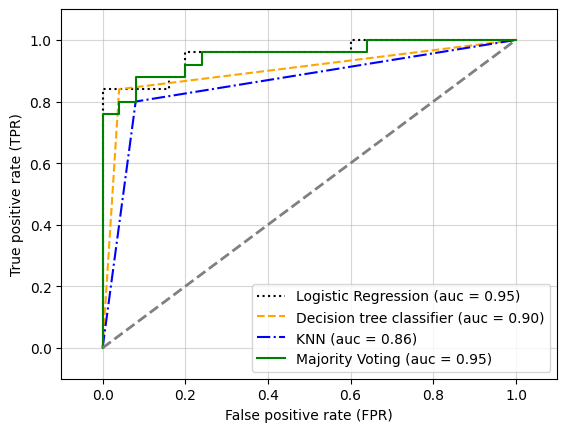

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
    in zip(all_clf, clf_labels, colors, linestyles):
    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
    y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
    y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
    color=clr,
    linestyle=ls,
    label=f'{label} (auc = {roc_auc:.2f})')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
    linestyle='--',
    color='gray',
    linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

In [50]:
len(clf_labels)

4

In [51]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1

y_max = X_train_std[:, 1].max() + 1

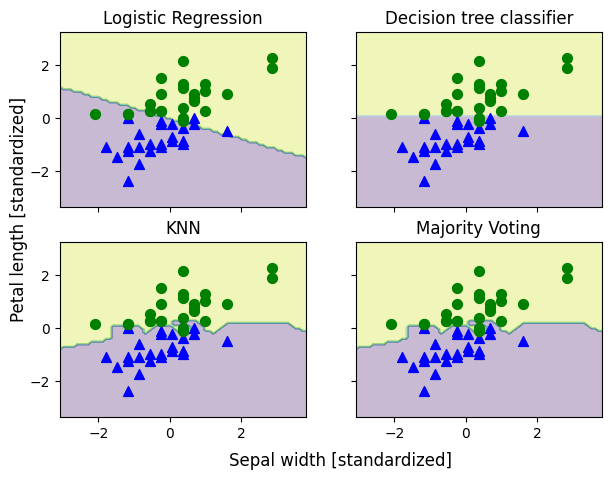

In [52]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
    np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2,
    sharex='col',
    sharey='row',
    figsize=(7, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]),
    all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
    X_train_std[y_train==0, 1],
    c='blue',
    marker='^',
    s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
    X_train_std[y_train==1, 1],
    c='green',
    marker='o',
    s=50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -5.,
    s='Sepal width [standardized]',
    ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5,
    s='Petal length [standardized]',
    ha='center', va='center',
    fontsize=12, rotation=90)
plt.show()


In [53]:
voting_clf.get_params()

{'estimators': [('lr',
   Pipeline(steps=[('sc', StandardScaler()),
                   ('clf', LogisticRegression(C=0.001, random_state=1))])),
  ('dt',
   Pipeline(steps=[('sc', StandardScaler()),
                   ('clf',
                    DecisionTreeClassifier(criterion='entropy', max_depth=1,
                                           random_state=1))])),
  ('knn',
   Pipeline(steps=[('sc', StandardScaler()),
                   ('clf', KNeighborsClassifier(n_neighbors=1))]))],
 'flatten_transform': True,
 'n_jobs': None,
 'verbose': False,
 'voting': 'soft',
 'weights': None,
 'lr': Pipeline(steps=[('sc', StandardScaler()),
                 ('clf', LogisticRegression(C=0.001, random_state=1))]),
 'dt': Pipeline(steps=[('sc', StandardScaler()),
                 ('clf',
                  DecisionTreeClassifier(criterion='entropy', max_depth=1,
                                         random_state=1))]),
 'knn': Pipeline(steps=[('sc', StandardScaler()),
                 ('clf', KN

In [54]:
from sklearn.model_selection import GridSearchCV
params = {'dt__clf__max_depth': [1, 2],
    'lr__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=voting_clf,
    param_grid=params,
    cv=10,
    scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=VotingClassifier(estimators=[('lr',
                                                     Pipeline(steps=[('sc',
                                                                      StandardScaler()),
                                                                     ('clf',
                                                                      LogisticRegression(C=0.001,
                                                                                         random_state=1))])),
                                                    ('dt',
                                                     Pipeline(steps=[('sc',
                                                                      StandardScaler()),
                                                                     ('clf',
                                                                      DecisionTreeClassifier(criterion='entropy',
                                                                                             max_depth=1,
                                                                                             random_state=1))])),
                                                    ('knn',
                                                     Pipeline(steps=[('sc',
                                                                      StandardScaler()),
                                                                     ('clf',
                                                                      KNeighborsClassifier(n_neighbors=1))]))],
                                        voting='soft'),
             param_grid={'dt__clf__max_depth': [1, 2],
                         'lr__clf__C': [0.001, 0.1, 100.0]},
             scoring='roc_auc')

In [55]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    mean_score = grid.cv_results_['mean_test_score'][r]
    std_dev = grid.cv_results_['std_test_score'][r]
    params = grid.cv_results_['params'][r]
    print(f'{mean_score:.3f} +/- {std_dev:.2f} {params}')

print(f'Best parameters: {grid.best_params_}')
print(f'ROC AUC : {grid.best_score_:.2f}')

0.983 +/- 0.05 {'dt__clf__max_depth': 1, 'lr__clf__C': 0.001}
0.983 +/- 0.05 {'dt__clf__max_depth': 1, 'lr__clf__C': 0.1}
0.967 +/- 0.10 {'dt__clf__max_depth': 1, 'lr__clf__C': 100.0}
0.983 +/- 0.05 {'dt__clf__max_depth': 2, 'lr__clf__C': 0.001}
0.983 +/- 0.05 {'dt__clf__max_depth': 2, 'lr__clf__C': 0.1}
0.967 +/- 0.10 {'dt__clf__max_depth': 2, 'lr__clf__C': 100.0}
Best parameters: {'dt__clf__max_depth': 1, 'lr__clf__C': 0.001}
ROC AUC : 0.98


Bagging

In [3]:
import pandas as pd
df_wine = pd.read_csv('wine.data',header=None)
df_wine.columns = ['Class label', 'Alcohol',
    'Malic acid', 'Ash',
    'Alcalinity of ash',
    'Magnesium', 'Total phenols',
    'Flavanoids', 'Nonflavanoid phenols',
    'Proanthocyanins',
    'Color intensity', 'Hue',
    'OD280/OD315 of diluted wines',
    'Proline']
# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol','OD280/OD315 of diluted wines']].values

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
    test_size=0.2,
    random_state=1,
    stratify=y)

In [14]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy',
    random_state=1,
    max_depth=None)
bag = BaggingClassifier(estimator=tree,
    n_estimators=500,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=True,
    bootstrap_features=False,
    n_jobs=1,
    random_state=1)


Decision tree performance

In [15]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies '
    f'{tree_train:.3f}/{tree_test:.3f}')

Decision tree train/test accuracies 1.000/0.833


Bagging Performance

In [16]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print(f'Bagging train/test accuracies '
    f'{bag_train:.3f}/{bag_test:.3f}')

Bagging train/test accuracies 1.000/0.917


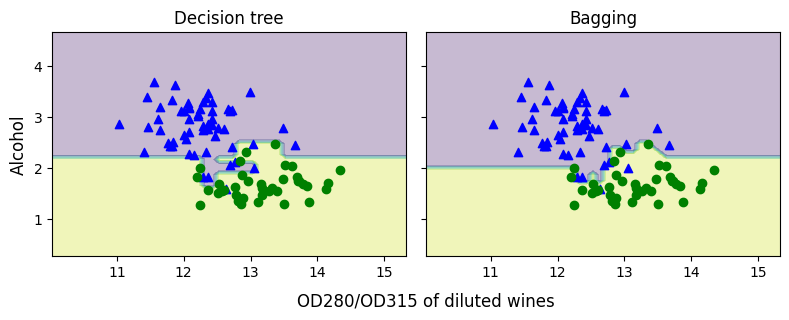

In [23]:
import numpy as np
import matplotlib.pyplot as plt
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
    np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2,
    sharex='col',
    sharey='row',
    figsize=(8, 3))
for idx, clf, tt in zip([0, 1],
    [tree, bag],
    ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],
    X_train[y_train==0, 1],
    c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0],
    X_train[y_train==1, 1],
    c='green', marker='o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.tight_layout()
plt.text(0, -0.2,
    s='OD280/OD315 of diluted wines',
    ha='center',
    va='center',
    fontsize=12,
    transform=axarr[1].transAxes)
plt.show()

(119, 2)